# Multinomial Music Genre Classification with K-Fold Cross-Validation 

## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



### Keywords
`Logistic Regression`, `K-Nearest Neighbor`, `Principal Component Analysis (PCA)`, `Gradient Boosting`.

## 1. Introduction

Music is known to bring people with a similar taste together in masses at the concerts of world-famous artists. However, as all matters of taste, there exists a multitude of different genres which are more or less separable. For example, hardly anyone would state that power metal and smooth jazz sounded alike, mainly because of the clear difference in tempo. 

For the purposes of this project, we focus on three different components, namely timbre, pitch, and rhythm. __Timbre__ describes the tonal color, which separates heavily distorted electric guitar from a clean piano [1]. __Pitch__ describes how low or high a sound is, separating very low notes found in bass-heavy electronic music from the high-pitched flutes in some classical pieces [2]. Finally, __rhythm__ describes the temporal structure of a given piece of music, like in the example given before [3]. 

Multiclass classification is a branch of machine learning with the purpose of creating classifications where similar items are grouped together. The basic idea in classification is to figuratively draw lines separating one class from all the other data. A rough example of this would be to say that all pictures that have a high enough level of green have grass in them. Multiclass classification is then performed by combining the information from many one-vs-all classifications [4]. A simple illustration of multiclass classification is as follows:

![](./images/multiclass.png)

In this project, our goal is to create a classifier that gives us the probability of each song belonging to ten different music genres using a given training dataset described in the next section. This classifier is then used to predict the genres of songs in a test set, and we aim to acheive the highest possible predictive __accuracy__, i.e., the ratio of correct predictions to the total number of predictions [5]. In addition to this, we also aim to achieve the lowest __logarithmic loss__, i.e., the uncertainty of a prediction based on how much it deviates from the actual class label [6].  


## 2. Data analysis

This section of the report will briefly highlight some of the characteristics of the training data. In addition to this, some figures and illustrations will be provided to support how the distribution of labels in the training data will affect the classification.

We start this section with importing all the necessary packages and defining utility functions used throughout the project.

In [1]:
'''
Dependencies
'''
# Import dependencies
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ipywidgets import IntProgress
from matplotlib.patches import Rectangle
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import metrics as met
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split as TTSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report as ClassRep
from sklearn.metrics import confusion_matrix as ConfMat
from sklearn.linear_model import Perceptron, LogisticRegression as LogReg
from sklearn import preprocessing, svm, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

/home/abdullah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
'''
The utility functions used throughout the project
'''

# Inspired by http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
# with a few changes.
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues,
                          print_matrix = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision = 2)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        if print_matrix: print("Normalized confusion matrix")
    else:
        if print_matrix: print('Confusion matrix, without normalization')

    if print_matrix: print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Write results to excel files for analysis
def output(acc, logloss, name):
    # Check input
    if (acc.shape != (6544,)) or (logloss.shape != (6544, 10)):
        print('wrong input shapes')
        return
    
    df_acc = pd.DataFrame(acc, index = pd.Series(range(1, 6545), name = 'Sample_id'), columns = ['Sample_label'])
    df_logloss = pd.DataFrame(logloss, index = pd.Series(range(1, 6545), name = 'Sample_id'), 
        columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 
                   'Class_8', 'Class_9', 'Class_10'])
    
    # Excel file for analysis
    writer = pd.ExcelWriter(name+'.xlsx', engine = 'xlsxwriter')
    df_acc.to_excel(writer, sheet_name = 'accuracy')
    df_logloss.to_excel(writer, sheet_name = 'logloss')
    writer.save()
    
    # Kaggle submissions
    df_acc.to_csv(name+'_acc.csv')
    df_logloss.to_csv(name+'_logloss.csv')

# Compute PCA
def compute_pca(Z, d):
    # Input: the N by D data matrix Z, the number of components d
    # Output: a d by D matrix W_pca, and all eigenvalues of Q
    
    # step1: compute the sample cov. matrix Q
    Q = Z.T.dot(Z) / Z.shape[0]

    #step2: compute the eigenvalues and eigenvectors (see introduction notebook)
    eigvalues, eigvectors = np.linalg.eig(Q)
    eigvectors = eigvectors.T
    
    #step3: Sort the eigenvectors by decreasing eigenvalues, choose the d largest eigenvalues, form W_pca
    W_pca = np.asarray([x for _, x in sorted(zip(eigvalues,eigvectors), key = lambda pair: -pair[0].real)][:d])
    
    return W_pca.real, eigvalues

# Visualize PCA error
def plot_error(eigvalues, max_d):
    x = range(1, max_d + 1)
    errors = [sum(eigvalues[d:]) for d in x]
    plt.plot(x, errors)
    plt.xlabel('Principal Components $d$')
    plt.ylabel('Reconstruction error $\mathcal{E}$')
    plt.title('Principal Components vs. the Reconstruction Error')
    plt.show()
    

In [3]:
'''
Data Import from Files
'''

# Reading Data into Numpy Arrays
XTrainData = pd.read_csv("train_data.csv", header = None).values
YTrainData = pd.read_csv("train_labels.csv", header = None).values
XTestData = pd.read_csv("test_data.csv", header = None).values

# Storing Numpy Arrays into DataFrames for better visualization
FeatureTrainData = pd.DataFrame(XTrainData)
LabelTrainData = pd.DataFrame(YTrainData)
FeatureTestData = pd.DataFrame(XTestData)
print("TRAIN DATA")
print("Total records in the train file: ", FeatureTrainData.shape[0])
print("Total features in the train file: ", FeatureTrainData.shape[1])
print("Total number of labels/classes in the train file: ", len(LabelTrainData[0].unique()), "\n")

print("TEST DATA")
print("Total records in the test file: ", FeatureTestData.shape[0], "\n")

print ("Portion of Training Data")
display(FeatureTrainData.head())

TRAIN DATA
Total records in the train file:  4363
Total features in the train file:  264
Total number of labels/classes in the train file:  10 

TEST DATA
Total records in the test file:  6544 

Portion of Training Data


,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
0,1040.7,2315.6,2839.1,2552.2,2290.4,1913.8,2152.6,1930.3,2079.3,1706.7,...,0.216490,0.36548,0.093584,0.166870,0.083426,0.118090,0.089792,0.074371,0.073162,0.059463
1,2309.4,4780.4,4055.7,3120.5,1979.9,2343.6,2634.2,3208.5,3078.0,3374.7,...,0.100670,0.14739,0.102560,0.213040,0.082041,0.080967,0.076450,0.052523,0.052357,0.055297
2,2331.9,4607.0,4732.3,5007.0,3164.9,3171.9,2915.7,3282.3,2400.0,1895.2,...,0.126760,0.36321,0.114200,0.223780,0.100770,0.186910,0.067270,0.061138,0.085509,0.049422
3,3350.9,6274.4,5037.0,4609.7,3438.8,3925.8,3746.4,3539.4,3053.7,3075.4,...,0.096479,0.28950,0.074124,0.201580,0.049032,0.130210,0.045800,0.080885,0.148910,0.042027
4,2017.6,3351.8,2924.9,2726.3,1979.9,1930.9,2083.4,1889.2,1695.4,1911.7,...,0.138340,0.38266,0.079402,0.063495,0.053717,0.086750,0.062090,0.048999,0.033159,0.070813


The training data consists of 4363 songs from 10 genres with 264 features for each song. The first things we want to check from our training data are the class distribution and the principal component analysis. The class distribution shows us if the data consists of equal proportions of each genre or not, while the principal component analysis and the reconstruction error show us whether the number of features could be reduced. By looking at the first principal components, it is also possible to understand what features really separate the classes from each other. The songs furthest away from each other on the first principal component would surely sound very different if we could listen to them.

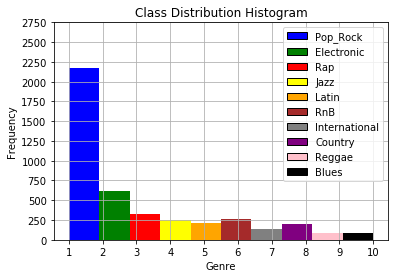

,Class,Percentage
1,Pop_Rock,49.919780
2,Electronic,14.164566
3,Rap,7.471923
4,Jazz,5.798762
5,Latin,4.904882
6,RnB,5.959202
7,International,3.231721
8,Country,4.469402
9,Reggae,2.108641
10,Blues,1.971121


In [4]:
# Class Distribution Histogram 
fig, ax = plt.subplots()
N, bins, patches = ax.hist(YTrainData, linewidth = 2)
plt.title("Class Distribution Histogram")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(np.arange(1, 11, step = 1))
plt.yticks(np.arange(0, 3000, step = 250))
colors = ['blue', 'green', 'red', 'yellow', 'orange', 'brown', 'gray', 'purple', 'pink', 'black']

for i in range(0, 10):
    patches[i].set_facecolor(colors[i])

# Histogram Legend
handles = [Rectangle((0, 0), 1, 1, color = c, ec = "k") for c in colors]
labels = ["Pop_Rock", "Electronic", "Rap", "Jazz", "Latin", "RnB", "International", "Country", "Reggae", "Blues"]
plt.legend(handles, labels)
plt.show()

unique, counts = np.unique(YTrainData, return_counts=True)
total = YTrainData.shape[0]
occurences = dict(zip(unique , (counts / total) * 100))
percentages = pd.DataFrame.from_dict(occurences, orient='index', columns=['Percentage'])
percentages['Class'] = pd.Series(np.asarray(labels), index=percentages.index)
percentages = percentages[['Class', 'Percentage']]
display(percentages)

From the class distribution histogram, it is obvious that the training data is heavily skewed towards the __Pop/Rock__ genre. The percentages of each class clearly depcit the fact that almost half of the data __49.92 %__ belongs to the __Pop/Rock__ class. This is problematic if the test data is distributed differently, as classifiers trained with this data will probably classify many songs from other genres as __Pop/Rock__ in order to increase accuracy. This has to be taken into account in training the models in order to get proper predictions.

## 3. Methods and Experiments

The platform for the entire methodology of this project was laid down in a sequential manner. After carefully analyzing the nature of the training data as well as the data to be tested, we decided to apply the following workflow to ensure efficient music genre classification [7]:   

![](./images/workflow3.png)

According to our workflow, the first step was to preprocess the data via normalization. The scikit learn library offered many options in this regard, but we decided to shortlist five options provided as follows:

   1. Standard Scaler 
   2. MinMax Scaler
   3. Robust Scaler along with Quantile Transformer *(to scale negative values to [0, 1])*
   4. Normalizer
    
In order to rate these options, we use Principal Component Analysis (PCA) plots to determine which option provided the best picture of how the classes were scattered as per their features. Next, we also plotted a graph of the __principal components__ against the __reconstruction error__.

The next step was to choose a suitable splitting technique for the training data to yield the most efficient classification. From two options of __normal train/test split__ and __K-Fold cross-validation__, the latter was the obvious choice as it is an effective method due to the fact that it generally results in a less biased or less optimistic estimate of the model skill than the former method [8]. In addition to this, shuffling of the train/test splits was enabled in the splitting algorithm to ensure that there was no __overfitting__ or __underfitting__ in the model due to the higly skewed nature of the original training data. 

In [5]:
'''
Data Normalization (Choose one and comment out the others for testing)
'''

# Initialization of Scalers/Transformers/Normalizers
standard_scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()
normalize = preprocessing.Normalizer()
quantile_transformer = preprocessing.QuantileTransformer(random_state = 0)


# Choice of Scaling/Transforming/Normalizing (Default = Standard Scaler)
choice = 1

if choice == 1: 
    # Normalize the data with Standard Scaler
    XTrainData = standard_scaler.fit_transform(XTrainData)
    XTestData = standard_scaler.fit_transform(XTestData)
elif choice == 2:
    # Normalize the data with MinMax Scaler
    XTrainData = min_max_scaler.fit_transform(XTrainData)
    XTestData = min_max_scaler.fit_transform(XTestData)
elif choice == 3:
    # Normalize the data with Robust Scaler
    XTrainData = robust_scaler.fit_transform(XTrainData)
    XTestData = robust_scaler.fit_transform(XTestData)
    # Scale data onto Uniform Distribution [0, 1] with Quantile Transformer
    XTrainData = quantile_transformer.fit_transform(XTrainData)
    XTestData = quantile_transformer.fit_transform(XTestData)
elif choice == 4:
    # Normalize the data with Normalize
    XTrainData = normalize.fit_transform(XTrainData)
    XTestData = normalize.fit_transform(XTestData)

    '''
Data Splits (Test and Train Sets)
'''

# Split choice (Normal = 0, Stratified K-Fold = 1)
split_choice = 1

# Multiple split ratios for test purposes 
splitRatios = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

if split_choice == 0:
    # Splitting the Test Data into Training and Testing Sets (both Features and Labels) (Normal)
    XTrainSet, XTestSet, YTrainSet, YTestSet = TTSplit(XTrainData, YTrainData, test_size = splitRatios[2])
elif split_choice == 1:
    # Splitting the Test Data into K Training, Validation and Testing Sets (both Features and Labels) (Stratified K-Fold)
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    skfSplits = skf.split(XTrainData, YTrainData)

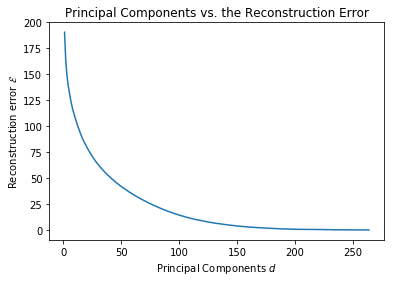

In [6]:
# Data has 264 features, calculate PCA and eigenvalues up to a full reconstruction
PCA, eigvalues = compute_pca(XTrainData, 264)

# plot the number of principal components vs the reconstruction error
plot_error(eigvalues, 264)

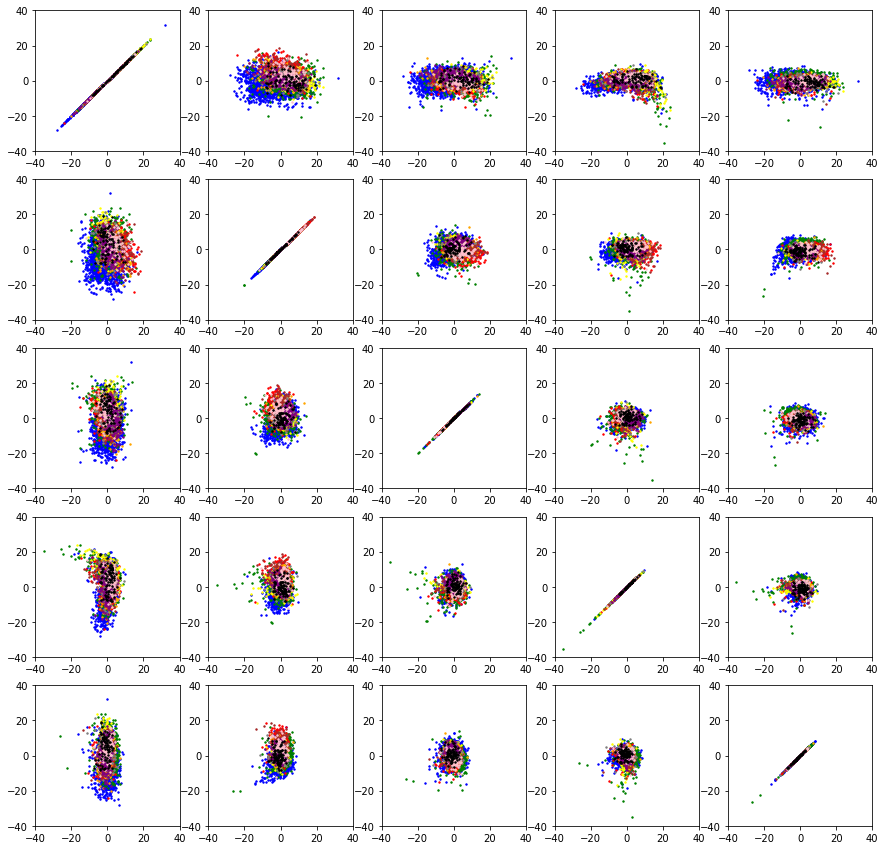

In [7]:
def plot_scatter(PCA, Z, Y):
    # get x for d = 10
    X_10d = np.matmul(PCA[:10, :], Z[:, :, None])[:, :, 0]
    colors = ['blue', 'green', 'red', 'yellow', 'orange', 'brown', 'gray', 'purple', 'pink', 'black']
    fig, axes = plt.subplots(5, 5)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(5):
        for j in range(5):
            for class_id in range(len(labels)):
                axes[i, j].scatter(X_10d[np.where(Y == class_id + 1),i], X_10d[np.where(Y == class_id + 1),j],
                                   marker = 'o', s = 2, c = colors[class_id], label = labels[i])
                axes[i, j].set_xlim([-40, 40])
                axes[i, j].set_ylim([-40, 40])
    plt.show()
    

plot_scatter(PCA, XTrainData, YTrainData)

From all the normalization options, it was evident from the figures that the __Standard Scaler__ provides the best depiction of the components and an ideal decreasing curve for the reconstruction error against increasing principal components. Also for the K-fold cross-validation, the number of splits was initiated from 2 and will be tuned later on in the workflow.

The principal component analysis dictates the fact that using half the original number of features, the reconstruction error is only around 10% of the maximum. This dimension reduction would mostly be beneficial in decreasing the running times, but as running times were no problem, we used the full data instead. From the scatterplots, we can see that in the first two principal directions, pop/rock is focused in the smaller values, and in directions 4 and 5, electronic music has some slight outliers. When examining the first principal component, it is visible that in the first 168 coefficients, there is an oscillation with a period of 24. Additionally, the next 48 clearly come in sets of 12 consecutive coefficients. What these observations mean is that the rhythm has an effect that is dependent on the band, with different weights for the 7 statistics. The coefficients for chroma do not seem to depend on the semitone, but only on the statistic. The effect of timbre is much less obvious in the first principal component.

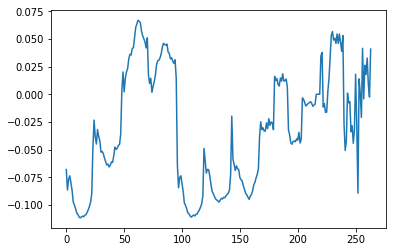

In [8]:
# This is not finalized, the point is to show the weights of coefficients in the given principal component.
plt.plot(PCA[0])
pd.DataFrame(PCA[0]).to_csv('pca.csv')

After choosing K-fold cross-validation for splitting the data, different classifier algorithms were tested on the data. The two algorithms optimized the furthest ended up being __logistic regression__ and __k nearest neighbors__. Logistic regression is based on binary classification as described in the introduction, while k nearest neighbors is a really simple and intuitive lazy learning method. The rest of the methods that were briefly examined are in the Appendix. 

In logistic regression, in order to know whether or not a given sample $\boldsymbol{x}$ belongs to a given class or not, the goal is to create a classifier $h^{(\boldsymbol{w})}(\boldsymbol{x}) = \boldsymbol{w}^T\boldsymbol{x}$ that minimizes the logistic loss $\mathcal{L}\big((\mathbf{x},y),h^{(\mathbf{w})}\big) = -y\log\big(\sigma(h^{(\mathbf{w})}(\mathbf{x}))\big)-(1-y)\log\big(1-\sigma(h^{(\mathbf{w})}(\mathbf{x}))\big)$, where $\sigma(z)= \frac{1}{1+{\rm exp}(-z)}$. $h^{(\boldsymbol{w})}(\boldsymbol{x})$ is often called the log-probability from which the actual probability of the sample belonging to the given class is calculated as $\sigma(h^{(\boldsymbol{w})}(\boldsymbol{x}))$. This methodology extends to multi-class problems simply by creating a described classifier for each class, then labeling each sample with the label corresponding to the class with the highest probability.

Unlike logistic regression, where we calculate the weights $\boldsymbol{w}$ based on the training set and the logistic loss, k nearest neighbors (or knn) is not trained in the same manner. K nearest neighbors is a lazy learning algorithm, meaning that the learning happens only when we classify new data points. In knn, each predicted sample is given the label that occurs most frequently among the $k$ training samples nearest to that point (Euclidian distance is often used as the metric). This is highly intuitive, as the predictions are clearly based on similar samples. However, it should also be clear that normalizing the data is crucial, as otherwise the data could be very tight in some dimensions and sparse in others.

In knn, the parameter to optimize is $k$, or how many neighbors we want to check for the classification. If $k$ is too small, just a few exceptions in an obvious cloud of samples belonging to a single class can cause the accuracy to drop. However, with $k$ too large, there is a risk of looking at neighbors too far from the predicted sample, thus causing errors. With logistic regression, the parameter $C$ is slightly harder to understand. What it does is add a regularization term of the form $\frac{1}{C} \| \boldsymbol{w} \|^2$ to the logistic loss, keeping the (absolute) values of $\boldsymbol{w}$ smaller than in an unregularized problem. This is useful in reducing overfitting, as large values of $\boldsymbol{w}$ often result from overfitting. On the other hand, too much regularization results in all the weights approaching zero, which is no good for the predictions. 

The code below is for finding the best value for $C$ in logistic regression or $k$ in k nearest neighbors.


IntProgress(value=0, description='Processing...', max=5)

IntProgress(value=0, description='KNN...', max=50)

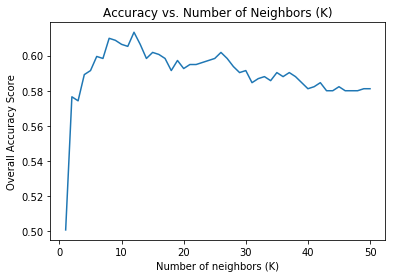

In [9]:
'''
Classifier choice
'''
# Choice of Scaling/Transforming/Normalizing (Default = (1) Logistic Regression, (2) K-Nearest Neighbor)
algo_choice = 2


'''
Stratified K-Fold Accuracy check to fetch best splits
'''

# Initiate progress bar
f1 = IntProgress(description = 'Processing...', min = 0, max = 5, orientation = 'horizontal')
display(f1)

if split_choice == 1:
    bestAcc = 0
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    for train_index, test_index in skf.split(XTrainData, YTrainData):
        XTrainSet, XTestSet = XTrainData[train_index], XTrainData[test_index] 
        YTrainSet, YTestSet = YTrainData[train_index], YTrainData[test_index]

        if algo_choice == 1:
            classify = LogReg(C = 0.1, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)
        elif algo_choice == 2:
            classify = KNeighborsClassifier(n_neighbors = 10, n_jobs = -2)
        classify.fit(XTrainSet, YTrainSet.ravel())
        predictTrain = classify.predict(XTrainSet)
        #print('Validation Accuracy: ', met.accuracy_score(YTestSet, classify.predict(XTestSet)))
        #print('Validation Log-loss: ', met.log_loss(YTestSet, classify.predict_proba(XTestSet)), '\n')
        if met.accuracy_score(YTestSet, classify.predict(XTestSet)) > bestAcc:
            train_idx = train_index
            test_idx = test_index
            bestAcc = met.accuracy_score(YTestSet, classify.predict(XTestSet))
            
        f1.value += 1
        
    XTrainSet, XTestSet = XTrainData[train_idx], XTrainData[test_idx] 
    YTrainSet, YTestSet = YTrainData[train_idx], YTrainData[test_idx]

# Terminate progress bar
f1.close()

'''
Iteratively check for best accuracy through multiple runs with different parameters 
(for both normal and K-fold splits)
'''
if algo_choice == 1:
    
    ''' 
    Multinomial Logistic Regression with Multiple Iterations
    PARAMETERS:
        Iterations = 7500
        Inverse Regularization Constant = 0.001 till 0.1
        Solver = SAG
        Penalty = L2
    '''

    # Metrics Initialization
    C = 0.001
    testAcc = []
    validAcc = []
    validLogloss = []
    C_array = []
    best_score = 0
    best_C = 0.001
    
    # Initiate progress bar
    f = IntProgress(description = 'LogReg...', min = 0, max = 39, orientation = 'horizontal')
    display(f)

    while C < 1:
        
        logreg = LogReg(C = C, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)

        # Fitting the refined training sets 
        logreg.fit(XTrainSet, YTrainSet.ravel())

        # Calculation of training accuracy
        predictTest = logreg.predict(XTestSet)
        predictTrain = logreg.predict(XTrainSet)

        # Display the calculated accuracies
        #print('Inverse of Regularization Constant (C): ', C)
        #print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainSet))
        #print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestSet))
        testAcc.append(met.accuracy_score(predictTrain, YTrainSet))
        validAcc.append(met.accuracy_score(predictTest, YTestSet))
        validLogloss.append(met.log_loss(YTestSet, logreg.predict_proba(XTestSet)))
        C_array.append(C)
    
        # Display final score from Logistic Regression
        score = logreg.score(XTestSet, YTestSet)
        #print('Final Score: ', score, '\n')
    
        # Set best parameters for alogrithm tuning 
        if score >= best_score:
            best_score = score
            best_C = C
        
        # Increment C for next iteration
        C = C * 1.2
        f.value += 1
        
    # Terminate progress bar
    f.close()
        
    '''
    Accuracy Plot for multiple Multinomial Logistic Regression Classifications
    '''
    plt.figure()
    line1, = plt.plot(C_array,testAcc)
    line2, = plt.plot(C_array,validAcc)
    line3, = plt.plot(C_array,validLogloss)
    plt.xlabel('Inverse of Regularization Parameter (C)')
    plt.ylabel('Accuracies and Log Loss')
    plt.title('Accuracies & Logarithmic Loss with changing Regularization Parameter')
    plt.xscale('log')
    plt.legend((line1, line2, line3), ('Training Accuracy', 'Validation Accuracy', 'Validation Log Loss'))
    plt.show()

elif algo_choice == 2:
    
    # Initiate progress bar
    f = IntProgress(description = 'KNN...', min = 0, max = 50, orientation = 'horizontal')
    display(f)
    
    ''' 
    KNN Classification with Mutiple Iterations
        PARAMETERS:
        Number of Neighbors = 2 till 50
    '''
    best_Acc = 0
    bestK = 1
    k_array = []
    acc = []
    for k in range(50):
        neigh = KNeighborsClassifier(n_neighbors = k + 1, n_jobs = -2)
        neigh.fit(XTrainSet, YTrainSet.ravel())
        predLabels = neigh.predict(XTestSet)
        conf = confusion_matrix(YTestSet, predLabels)
        accuracy = np.trace(conf) / np.sum(conf)
        k_array.append(k + 1)
        acc.append(accuracy)
        if accuracy >= best_Acc:
            best_Acc = accuracy
            bestK = k
        
        f.value += 1
        #print('Accuracy:', accuracy,'with', k + 1, 'neighbors')
        
    # Terminate progress bar
    f.close()
        
    '''
    Accuracy Plot for multiple KNN Classifications
    '''
    plt.figure()
    plt.plot(k_array, acc)
    plt.xlabel('Number of neighbors (K)')
    plt.ylabel('Overall Accuracy Score')
    plt.title('Accuracy vs. Number of Neighbors (K)')
    plt.show()

For logistic regression, the best value for $C$ seems to be roughly 0.015. This can be read from the figure above as the point where the validation accuracy starts decreasing because of too weak regularization leading to overfitting. For KNN, the optimal number of neighbors is roughly 15, but the accuracy remains very similar with up to 30 neighbors and can deviate with each and every trial run. 

## 4. Results

For logistic regression, the best validation accuracy was 67% with a log-loss of 1.10. After those basic results, we have two confusion matrices for a single algorithm. A confusion matrix in its simplest form shows how many songs in genre i were classified in genre j. For a perfect classification, the confusion matrix is a diagonal matrix, as all elements not on the diagonal are false classifications. The total accuracy of the method can be calculated from the confusion matrix as the ratio between the trace and sum of all elements. The lower confusion matrix has been simply scaled so that the sum of each row is 1. From the confusion matrices, we can see that there are differences in how well the different classes are predicted. The dark leftmost column in the lower confusion matrix tells us that a big part of most of the genres is predicted as Pop/Rock. 

For KNN, the accuracy was clearly lower, 61% at highest and the log-loss was also considerably worse at 4.2, and even more, songs were classified as Pop/Rock locally.

The best accuracies and log-losses (on Kaggle) of the algorithms:

| Algorithm                 | Accuracy | Log-loss |
|---------------------------|----------|----------|
| Logistic Regression       | 65.2%    | 0.17     |
| K-Nearest Neighbors (KNN) | 57.5%    | 0.57     |
| Gradient Boosting         | 63.3%    | 0.18     |

Comparing the Kaggle results to the local ones, the deviation between the log-loss was substantial for KNN as compared to logistic regression and gradient boosting. We shifted the implementation of gradient boosting to the Appendix as the workflow was more properly implemented for KNN and logistic regression. 


Results for K-Nearest Neighbor 

Best Number of Neighbors (K):  12
Validation Accuracy:  0.6133486766398158
Validation Log-loss:  4.242937317493665 

Confusion Matrix for K-Nearest Neighbor 



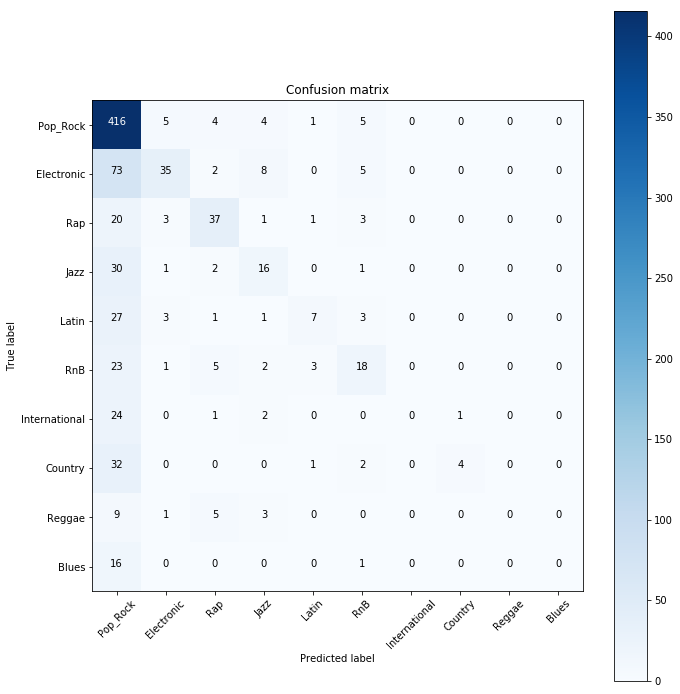

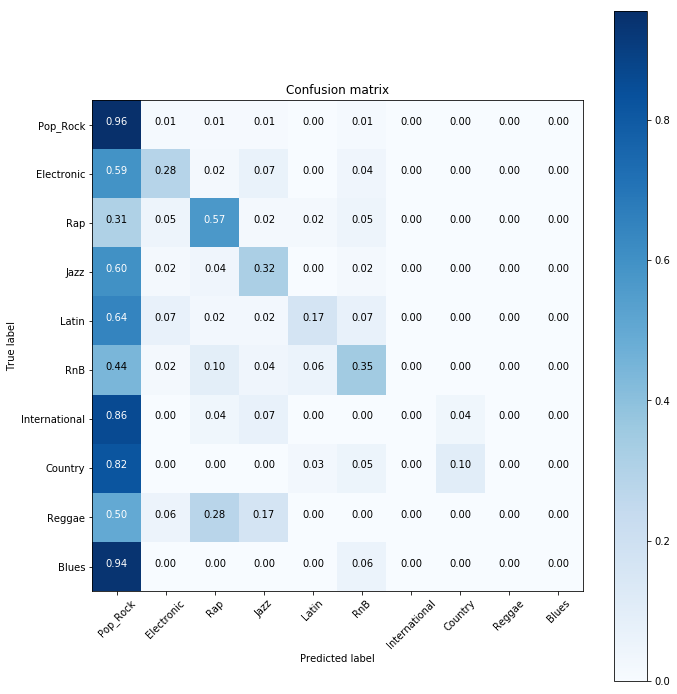

In [10]:
if algo_choice == 1:
    
    '''
    Best Multinomial Logistic Regression Classification (with tuned parameters)
    '''
    logreg = LogReg(C = best_C, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)
    logreg.fit(XTrainSet, YTrainSet.ravel())
    predictTrain = logreg.predict(XTrainSet)
    print('Results for Logistic Regression \n')
    print('Best Inverse of Regularization Constant (C): ', best_C)
    print('Validation Accuracy: ', met.accuracy_score(YTestSet, logreg.predict(XTestSet)))
    print('Validation Log-loss: ', met.log_loss(YTestSet, logreg.predict_proba(XTestSet)), '\n')
    
    # Write down predictions to spreadsheet to be forwarded to Kaggle  
    output(logreg.predict(XTestData).ravel(), logreg.predict_proba(XTestData), 'logreg')
    
    # Plot Confusion matrix for Logistic Regression
    print('Confusion Matrix for Logistic Regression \n')
    class_names = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']
    plt.figure(figsize = (10, 10))
    plot_confusion_matrix(YTestSet, logreg.predict(XTestSet), classes = class_names, normalize = False)
    plt.figure(figsize = (10, 10))
    plot_confusion_matrix(YTestSet, logreg.predict(XTestSet), classes = class_names, normalize = True)
    
    
elif algo_choice == 2:

    '''
    Best KNN Classification (with tuned parameters)
    '''
    neigh = KNeighborsClassifier(n_neighbors = bestK + 1, n_jobs = -2)
    neigh.fit(XTrainSet, YTrainSet.ravel())
    predLabels = neigh.predict(XTestSet)
    conf = confusion_matrix(YTestSet, predLabels)
    accuracy = np.trace(conf) / np.sum(conf)
    logloss = neigh.predict_proba(XTestSet)
    print('Results for K-Nearest Neighbor \n')
    print('Best Number of Neighbors (K): ', bestK + 1)
    print('Validation Accuracy: ', met.accuracy_score(YTestSet, neigh.predict(XTestSet)))
    print('Validation Log-loss: ', met.log_loss(YTestSet, neigh.predict_proba(XTestSet)), '\n')
    
    # Write down predictions to spreadsheet to be forwarded to Kaggle.  
    output(neigh.predict(XTestData).ravel(), neigh.predict_proba(XTestData), 'knn')
    
    # Plot Confusion matrix for Logistic Regression
    print('Confusion Matrix for K-Nearest Neighbor \n')
    class_names = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']
    plt.figure(figsize = (10, 10))
    plot_confusion_matrix(YTestSet, neigh.predict(XTestSet), classes = class_names, normalize = False)
    plt.figure(figsize = (10, 10))
    plot_confusion_matrix(YTestSet, neigh.predict(XTestSet), classes = class_names, normalize = True)

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *

Based on the results gained from the experiments conducted above, it can be clearly stated that a model trained using logistic regression performs much better as compared to KNN. We will not include gradient boosting in this comparison as proper parameter tuning was not performed for this classifier. The __confusion matrix__ a clear depiction of the results points out that there are many cases of _false positives_ (FP) in the case of the Pop/Rock genre and consequently many _false negatives_ (FN) as well in the case of the rest of the genres [9]. This phenomenon implies that the model trained for the task was biased towards the Pop/Rock genre based on the training data.

The two metrics of accuracy, i.e, the sum of all instances of _true positives_ (TP) and _true negatives_ (TN) of all the genres, and log-loss (the difference between the real and the predicted labels) signify the message of confusion matrix numerically. As evident from the ~33% of the dataset being misclassified, it can be inferred that the imbalance in the original dataset to the Pop/Rock genre was a major factor in this misclassification. The class distribution percentages along with the PCA plots highlighted this fact.

Following the literature, we managed to scale the data in order to remove meaningless data (outliers) from the dataset taking our initial naive accuracy from around 45% to 52% locally for the algorithms. The next step was to make sure that the model created considers all segments of the data for the training phase and does not just slice the data from one location every time. Hence after introducing shuffling and also playing around with the split ratio, we reached figures of around 57% for the accuracy. The next phase was to introduce validation coupled with multiple iterations of finding the best combination of splits. This step really boosted the accuracy values to above 60% and brought the log-loss under 1, a significant improvement from where we had started earlier. The final step we took was to tune the classifier parameters to get the best out of the data. We performed multiple iterations with different combinations of parameter values and picked the one giving the highest accuracy and log-loss values. This final improvement brought the accuracy to ~67% and the log-loss to under 0.2. In summary, the literature laid the foundation for the workflow and in turn lead to the significant improvement of the model itself.

There was much more to explore in the experiments which we weren't able to complete within the given timeframe. Some improvements could have been explored easily starting with the testing of algorithm classifiers such as Random Forest and LinearSVM etc. after parameter tuning. Secondly, another important process we failed to add in our workflow was to change the classifier thresholds for labeling the classes __True__ or __False__. By plotting __Receiver Operating Curves__ (ROC) to visualize the relation between the _true positive rate_ (TPR) and _false positive rate_ (FPR) and subsequently plotting the __Area under the Curve__ (AUC) for the ROC would have greatly benefitted us in finding the right threshold for classifying a particular genre.

Overall, this study managed to answer most of our questions concerning the nature of the dataset, the techniques to create, validate, train and lastly test a model coupled with the improvisation of the model by tuning the parameters according to the dataset at hand. Although the results seemed satisfactory, some questions still remained unanswered such as _" when is it not suitable to use a certain classification algorithm based on the given data only?"_ 

## 6. References

[1]    https://en.wikipedia.org/wiki/Timbre

[2]    https://en.wikipedia.org/wiki/Pitch_(music)

[3]    https://en.wikipedia.org/wiki/Rhythm

[4]    http://scikit-learn.org/stable/modules/multiclass.html

[5]    https://developers.google.com/machine-learning/crash-course/classification/accuracy

[6]    http://wiki.fast.ai/index.php/Log_Loss

[7]    https://www.ritchieng.com/machine-learning-evaluate-classification-model/

[8]    https://machinelearningmastery.com/k-fold-cross-validation/

[9]    https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative

## Appendix

In [ ]:
# Trial runs of all relevant Classifiers on the data (for test purposes) (Not optimized due to limited time)

''' 
Gradient Boosting Classifier on the data
    Default Settings
'''

'''
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(XTrainSet, YTrainR.ravel())
predictTest = gbc.predict(XTestSet)
predictTrain = gbc.predict(XTrainSet)
score = gbc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''



''' 
Random Forest Classifier on the data
    Default Settings
'''
'''
rfc = ensemble.RandomForestClassifier()
rfc.fit(XTrainSet, YTrainR.ravel())
predictTest = rfc.predict(XTestSet)
predictTrain = rfc.predict(XTrainSet)
score = rfc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''


''' 
RBF SVM Classifier on the data
    Default Settings
'''

'''
rbfsvm = svm.SVC()
rbfsvm.fit(XTrainSet, YTrainR.ravel())
predictTest = rbfsvm.predict(XTestSet)
predictTrain = rbfsvm.predict(XTrainSet)
score = rbfsvm.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''


''' 
Perceptron Classifier on the data
    Default Settings
'''

'''
clf = Perceptron(shuffle = True, tol = 1e-3, max_iter = 1000, random_state = 16)
clf.fit(XTrainSet, YTrainSet.ravel())
print(clf.score(XTrainSet, YTrainSet.ravel()))
print(clf.score(XTestSet, YTestSet.ravel()))
'''